Sample data for 20MICRONS:
            Open  High    Low  Close    Volume   Returns  MA_50  MA_200
Date                                                                   
2008-10-06  80.0  80.0  31.60  33.65  11750865       NaN    NaN     NaN
2008-10-07  32.0  38.0  27.85  30.10   4556711 -0.105498    NaN     NaN
2008-10-08  28.0  29.2  25.10  26.50   1232192 -0.119601    NaN     NaN
2008-10-10  24.9  24.9  21.65  23.20    603964 -0.124528    NaN     NaN
2008-10-13  24.3  26.6  23.30  24.65    449346  0.062500    NaN     NaN


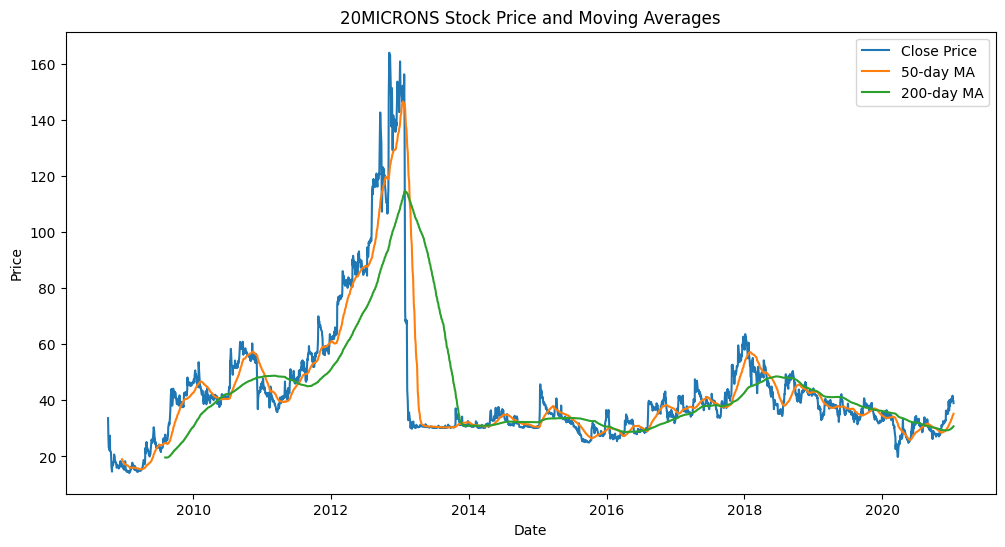

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# Step 1: Load the data
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    return df

# Step 2: Preprocess the data
def preprocess_data(df):
    # Set Date as index
    df.set_index('Date', inplace=True)
    
    # Remove unnecessary columns
    columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[columns_to_keep]
    
    # Handle missing values
    df = df.ffill()  # Replace deprecated method with ffill()
    
    # Convert Volume to numeric, removing any non-numeric characters
    df.loc[:, 'Volume'] = pd.to_numeric(df['Volume'].replace({',': ''}, regex=True), errors='coerce')
    
    # Calculate additional features
    df.loc[:, 'Returns'] = df['Close'].pct_change()
    df.loc[:, 'MA_50'] = df['Close'].rolling(window=50).mean()
    df.loc[:, 'MA_200'] = df['Close'].rolling(window=200).mean()
    
    return df

# Step 3: Load and preprocess all files
def load_and_preprocess_all_data(directory):
    all_data = {}
    for file_path in glob(os.path.join(directory, '*.csv')):
        symbol = os.path.basename(file_path).split('-')[0]
        df = load_data(file_path)
        df = preprocess_data(df)
        all_data[symbol] = df
    return all_data

# Load and preprocess all data
ns_data_dir = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\stock-data\historical_ns_data"
bo_data_dir = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\stock-data\historical_bo_data"

ns_data = load_and_preprocess_all_data(ns_data_dir)
bo_data = load_and_preprocess_all_data(bo_data_dir)

# Example: Print the first few rows of the first stock in ns_data
first_stock = list(ns_data.keys())[0]
print(f"Sample data for {first_stock}:")
print(ns_data[first_stock].head())

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(ns_data[first_stock].index, ns_data[first_stock]['Close'], label='Close Price')
plt.plot(ns_data[first_stock].index, ns_data[first_stock]['MA_50'], label='50-day MA')
plt.plot(ns_data[first_stock].index, ns_data[first_stock]['MA_200'], label='200-day MA')
plt.title(f'{first_stock} Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from glob import glob
import os
from concurrent.futures import ThreadPoolExecutor

# Function to load and preprocess data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df = df.ffill().bfill().interpolate()  # Handle missing values
    df['Returns'] = df['Close'].pct_change()
    return df

# Isolation Forest anomaly detection with PCA for dimensionality reduction
def detect_anomalies_isolation_forest(df, features, contamination=0.01):
    pca = PCA(n_components=2)  # Reduce to 2 components for faster computation
    reduced_features = pca.fit_transform(df[features])
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df['Anomaly'] = iso_forest.fit_predict(reduced_features)
    anomalies = df[df['Anomaly'] == -1]
    return anomalies

# Interpolate anomalies in the DataFrame
def fix_anomalies_with_interpolation(df, anomalies):
    df.loc[anomalies.index] = np.nan
    return df.interpolate()

# Process and clean a single stock file
def process_stock_file(file_path, output_directory, suffix):
    stock_name = os.path.basename(file_path).split('-')[0]
    df = load_and_preprocess(file_path)
    
    # Detect anomalies using Isolation Forest
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    anomalies = detect_anomalies_isolation_forest(df, features)
    
    # Fix anomalies by interpolation
    cleaned_df = fix_anomalies_with_interpolation(df, anomalies)
    
    # Save cleaned DataFrame to CSV with the suffix (-ns or -bo)
    cleaned_file_path = os.path.join(output_directory, f"{stock_name}-{suffix}.csv")
    cleaned_df.to_csv(cleaned_file_path)
    
    return stock_name, cleaned_df

# Process all stock files in parallel and store cleaned data
def process_and_clean_all_stocks(directory, output_directory, suffix):
    cleaned_data = {}
    file_paths = glob(os.path.join(directory, '*.csv'))
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_stock_file, file_path, output_directory, suffix): file_path for file_path in file_paths}
        for future in futures:
            stock_name, cleaned_df = future.result()
            cleaned_data[stock_name] = cleaned_df
    
    return cleaned_data

# Directory paths for NSE and BSE data
nse_data_dir = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\stock-data\historical_ns_data"
bse_data_dir = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\stock-data\historical_bo_data"
output_dir = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data"

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process and clean NSE and BSE data separately
print("Processing NSE data...")
nse_cleaned_data = process_and_clean_all_stocks(nse_data_dir, output_dir, "ns")

print("\nProcessing BSE data...")
bse_cleaned_data = process_and_clean_all_stocks(bse_data_dir, output_dir, "bo")

# Example: Access and print cleaned data for "20MICRONS" from NSE
if "20MICRONS" in nse_cleaned_data:
    print("\nCleaned Data for 20MICRONS (NSE):")
    print(nse_cleaned_data["20MICRONS"].head())


Processing NSE data...

Processing BSE data...

Cleaned Data for 20MICRONS (NSE):
            Open  High    Low  Close    Volume   Returns  Anomaly
Date                                                             
2008-10-06   NaN   NaN    NaN    NaN       NaN       NaN      NaN
2008-10-07   NaN   NaN    NaN    NaN       NaN       NaN      NaN
2008-10-08   NaN   NaN    NaN    NaN       NaN       NaN      NaN
2008-10-10  24.9  24.9  21.65  23.20  603964.0 -0.124528      1.0
2008-10-13  24.3  26.6  23.30  24.65  449346.0  0.062500      1.0


In [7]:
# Summary statistics for a sample stock
df = nse_cleaned_data['20MICRONS']  # Replace with the stock symbol of interest

# Display basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


              Open         High          Low        Close        Volume  \
count  3038.000000  3038.000000  3038.000000  3038.000000  3.038000e+03   
mean     43.054979    44.097737    41.844264    42.730044  9.721614e+04   
std      22.742237    23.260717    22.201424    22.565174  1.490832e+05   
min      14.050000    14.400000    13.200000    14.200000  5.110000e+02   
25%      30.950000    31.450000    30.400000    30.712500  2.286525e+04   
50%      37.000000    37.900000    35.925000    36.650000  5.185200e+04   
75%      45.487500    46.600000    43.800000    44.837500  1.013515e+05   
max     158.900000   159.550000   152.000000   152.800000  1.349380e+06   

           Returns  Anomaly  
count  3038.000000   3038.0  
mean      0.000517      1.0  
std       0.031261      0.0  
min      -0.200000      1.0  
25%      -0.013884      1.0  
50%      -0.001642      1.0  
75%       0.011097      1.0  
max       0.202055      1.0  
Open       3
High       3
Low        3
Close      3
Vo

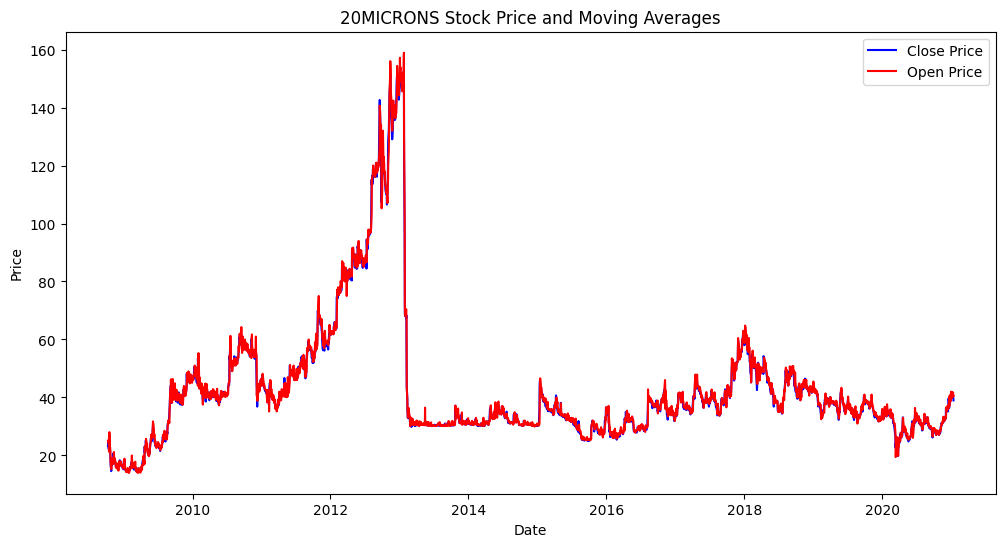

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index,df['Open'], label='Open Price', color='red')
plt.title('20MICRONS Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


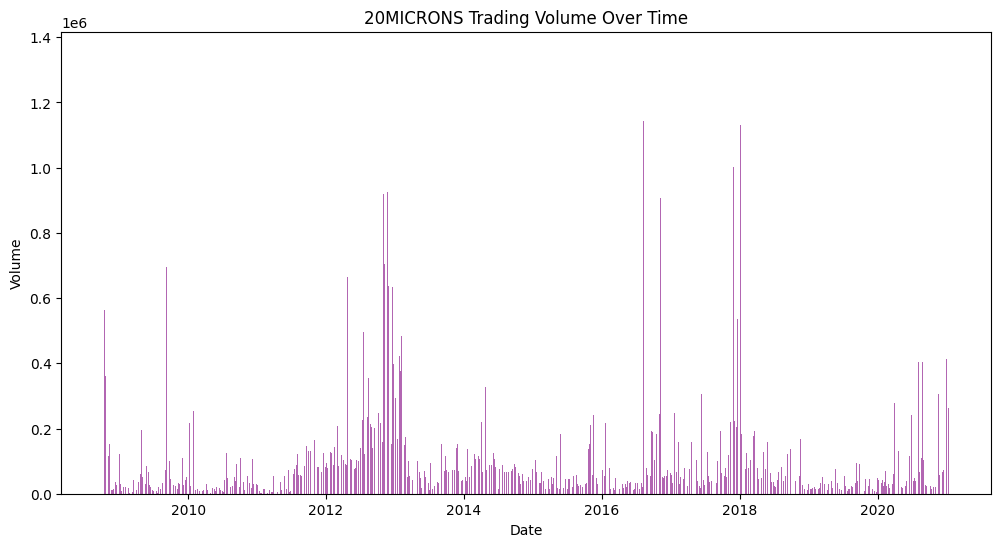

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['Volume'], color='purple', alpha=0.6)
plt.title('20MICRONS Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


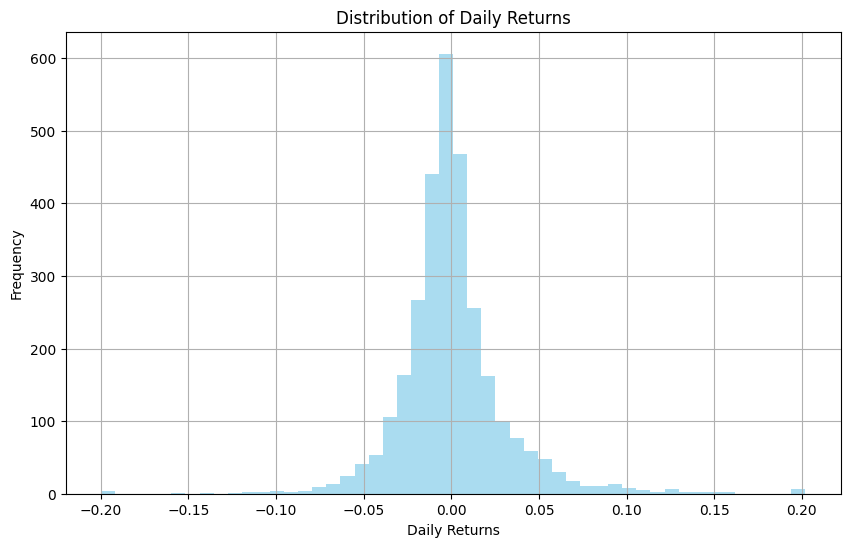

In [10]:
# Plot histogram for returns
df['Returns'].hist(bins=50, figsize=(10, 6), color='skyblue', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()


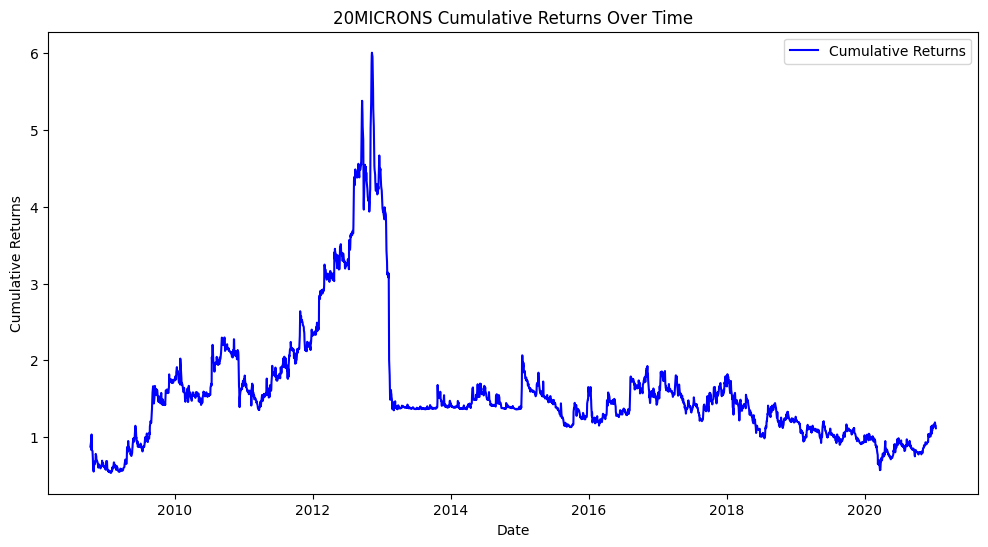

In [11]:
# Calculate cumulative returns
df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Returns'], label='Cumulative Returns', color='blue')
plt.title('20MICRONS Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


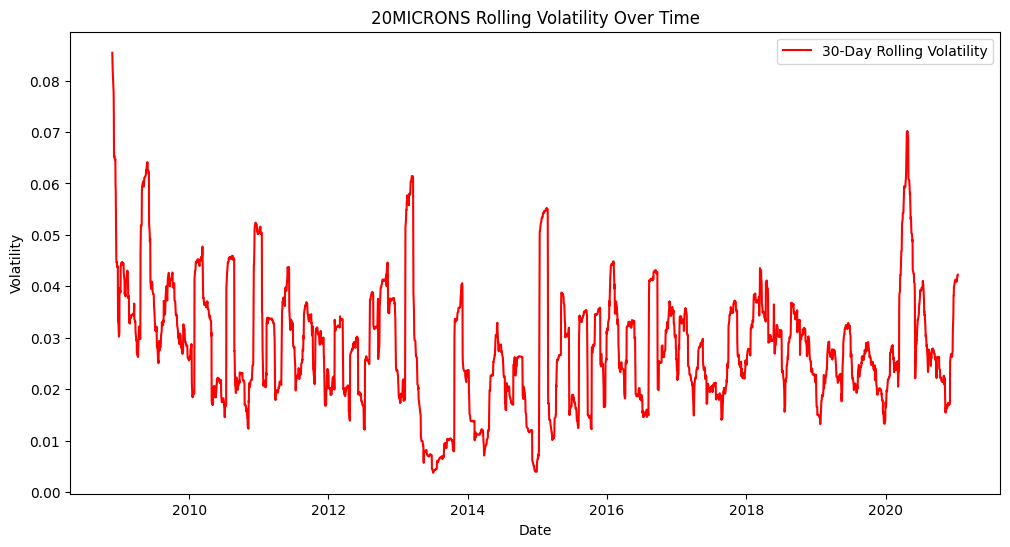

In [12]:
# Calculate rolling standard deviation (volatility)
df['Rolling_Volatility'] = df['Returns'].rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rolling_Volatility'], label='30-Day Rolling Volatility', color='red')
plt.title('20MICRONS Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


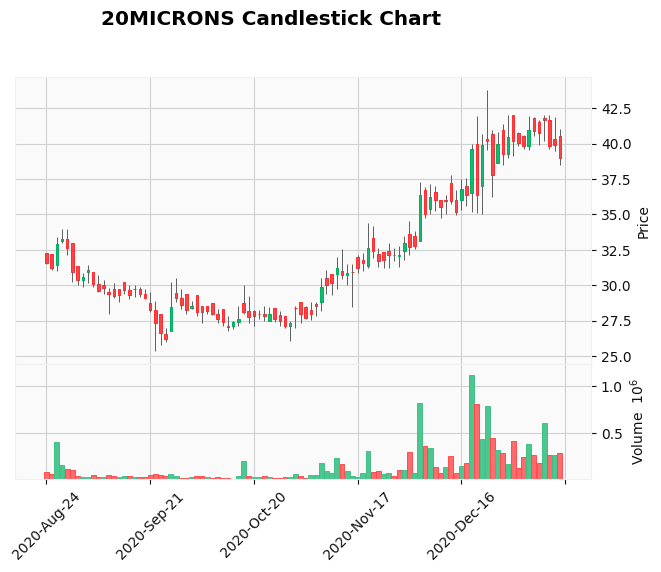

In [13]:
import mplfinance as mpf

mpf.plot(
    df[-100:],  # Last 100 rows for better visualization
    type='candle',
    volume=True,
    title='20MICRONS Candlestick Chart',
    style='yahoo'
)


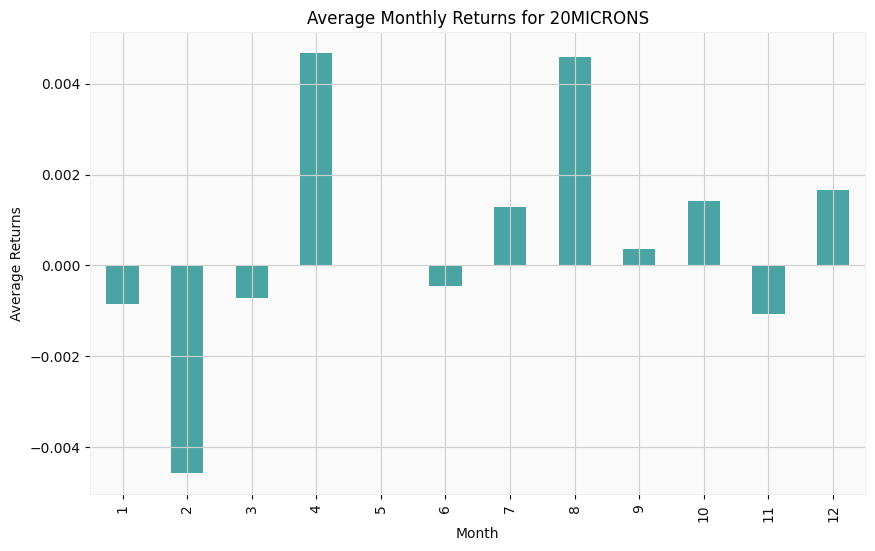

In [14]:
# Extract month from Date index
df['Month'] = df.index.month

# Group by month and calculate average returns
monthly_avg_returns = df.groupby('Month')['Returns'].mean()

# Plot monthly average returns
monthly_avg_returns.plot(kind='bar', figsize=(10, 6), color='teal', alpha=0.7)
plt.title('Average Monthly Returns for 20MICRONS')
plt.xlabel('Month')
plt.ylabel('Average Returns')
plt.show()


In [15]:
import pandas as pd
import numpy as np
import os
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler

def load_all_csvs(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = []
    
    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        df['Stock'] = file
        dataframes.append(df)
    
    return pd.concat(dataframes, ignore_index=False)

def add_technical_indicators(df):
    df = df.copy()
    
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['EMA_12'] = EMAIndicator(df['Close'], window=12).ema_indicator()
    df['EMA_26'] = EMAIndicator(df['Close'], window=26).ema_indicator()

    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Hist'] = macd.macd_diff()

    df['RSI'] = RSIIndicator(df['Close']).rsi()

    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()

    bb = BollingerBands(df['Close'])
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Middle'] = bb.bollinger_mavg()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']

    vwap = VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume'])
    df['VWAP'] = vwap.volume_weighted_average_price()

    df['Price_Change'] = df['Close'].diff()
    df['Returns'] = df['Close'].pct_change(fill_method=None)
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()
    df['Daily_Range'] = df['High'] - df['Low']
    df['Daily_Range_Pct'] = df['Daily_Range'] / df['Open']
    df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_MA_50'] = df['Volume'].rolling(window=50).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    
    return df

def prepare_sequences(df, sequence_length=60, forecast_horizon=5):
    feature_columns = ['Close', 'Volume', 'RSI', 'MACD', 'BB_Width', 
                       'Daily_Volatility', 'Volume_Ratio', 'Price_Position']
    
    df = df.dropna(subset=feature_columns)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[feature_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=feature_columns, index=df.index)
    
    X, y = [], []
    
    for i in range(len(scaled_df) - sequence_length - forecast_horizon + 1):
        X.append(scaled_df.iloc[i:(i + sequence_length)].values)
        y.append(scaled_df.iloc[i + sequence_length:i + sequence_length + forecast_horizon]['Close'].values)
    
    return np.array(X), np.array(y), scaler

if __name__ == "__main__":
    folder_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data"
    stock_data = load_all_csvs(folder_path)
    
    enhanced_data = add_technical_indicators(stock_data)
    
    X, y, scaler = prepare_sequences(enhanced_data)
    
    print("Feature engineering complete.")
    print(f"Input shape: {X.shape}")
    print(f"Output shape: {y.shape}")
    print("\nFeatures added:", enhanced_data.columns.tolist())


Feature engineering complete.
Input shape: (7015920, 60, 8)
Output shape: (7015920, 5)

Features added: ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Anomaly', 'Stock', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'Stoch_K', 'Stoch_D', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'VWAP', 'Price_Change', 'Daily_Volatility', 'Daily_Range', 'Daily_Range_Pct', 'Price_Position', 'Volume_MA_20', 'Volume_MA_50', 'Volume_Ratio']


In [16]:
print(enhanced_data.isna().sum())
print(enhanced_data.describe())


Open                0
High                0
Low                 0
Close               0
Volume              0
Returns             0
Anomaly             0
Stock               0
SMA_20              0
SMA_50              0
EMA_12              0
EMA_26              0
MACD                0
MACD_Signal         0
MACD_Hist           0
RSI                 0
Stoch_K             0
Stoch_D             0
BB_Upper            0
BB_Middle           0
BB_Lower            0
BB_Width            0
VWAP                0
Price_Change        0
Daily_Volatility    0
Daily_Range         0
Daily_Range_Pct     0
Price_Position      0
Volume_MA_20        0
Volume_MA_50        0
Volume_Ratio        0
dtype: int64
               Open          High           Low         Close        Volume  \
count  7.015984e+06  7.015984e+06  7.015984e+06  7.015984e+06  7.015984e+06   
mean   3.853361e+02  3.922965e+02  3.780670e+02  3.845996e+02  6.700380e+05   
std    1.575280e+03  1.598258e+03  1.549876e+03  1.572025e+03  5.006

In [17]:
enhanced_data = enhanced_data.astype({
    "Close": "float32",
    "Volume": "float32",
    "RSI": "float32",
    "MACD": "float32",
    "BB_Width": "float32",
    "Daily_Volatility": "float32",
    "Volume_Ratio": "float32",
    "Price_Position": "float32",
})


In [18]:
np.save("X_stock_sequences.npy", X)
np.save("y_stock_targets.npy", y)


In [19]:
from scipy.stats.mstats import winsorize
enhanced_data["Price_Change"] = winsorize(enhanced_data["Price_Change"], limits=[0.01, 0.01])
enhanced_data["Daily_Volatility"] = winsorize(enhanced_data["Daily_Volatility"], limits=[0.01, 0.01])


In [20]:
enhanced_data = enhanced_data[(enhanced_data["Close"] > 0) & (enhanced_data["Volume"] > 1)]


In [21]:
enhanced_data["Price_Position"] = enhanced_data["Price_Position"].clip(0, 1)


In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Selecting only 8 features for LSTM input
lstm_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'SMA_20', 'SMA_50']

scaler = MinMaxScaler()
enhanced_data[lstm_features] = scaler.fit_transform(enhanced_data[lstm_features])

# Ensure the number of rows is a multiple of 60
num_rows = len(enhanced_data) - (len(enhanced_data) % 60)  # Trim excess rows
X = enhanced_data[lstm_features].iloc[:num_rows].values.reshape(-1, 60, 8)
y = enhanced_data[['Close', 'Returns', 'Anomaly', 'RSI', 'MACD']].iloc[:num_rows].values

print(f"Corrected Input Shape: {X.shape}, Output Shape: {y.shape}")


Corrected Input Shape: (116824, 60, 8), Output Shape: (7009440, 5)


In [23]:
# Selecting target columns
target_columns = ['Close', 'Returns', 'Anomaly', 'RSI', 'MACD']

# Reshape target to match X
y = enhanced_data[target_columns].iloc[:num_rows].values.reshape(-1, 60, 5)[:, -1, :]

print(f"Fixed Output Shape: {y.shape}")  # Should be (116824, 5)


Fixed Output Shape: (116824, 5)


In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(60, 8)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output layer (5 target values)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,957 (210.77 KB)

 Trainable params: 53,957 (210.77 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 128s 38ms/step - loss: 1885.0165 - mae: 5.5315 - val_loss: 344.5957 - val_mae: 3.7697
Epoch 2/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 138s 42ms/step - loss: 2652.3022 - mae: 4.5531 - val_loss: 344.8241 - val_mae: 3.7670
Epoch 3/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 143s 43ms/step - loss: 1562.6530 - mae: 4.3800 - val_loss: 344.4995 - val_mae: 3.7645
Epoch 4/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 145s 44ms/step - loss: 1895.3948 - mae: 4.3564 - val_loss: 344.4927 - val_mae: 3.7630
Epoch 5/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 139s 42ms/step - loss: 2402.4675 - mae: 4.4028 - val_loss: 344.5451 - val_mae: 3.7632
Epoch 6/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - loss: 3339.9661 - mae: 4.5160 - val_loss: 344.6030 - val_mae: 3.7753
Epoch 7/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - loss: 1896.7517 - mae: 4.3665 - val_loss: 344.6137 - val_mae: 3.7600
Epoch 8/20
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - loss: 2294.5547 - mae: 4.4718 - val_loss: 345

In [26]:
loss, mae = model.evaluate(X, y)
print(f"Test Loss: {loss}, Test MAE: {mae}")

model.save('lstm_stock_model.h5')


3651/3651 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 1546.3258 - mae: 4.5696


Test Loss: 1773.2276611328125, Test MAE: 4.308382987976074


In [29]:
# Get the correct number of samples
num_samples = scaled_features.shape[0] // 60  # Ensure it's a multiple of 60
trimmed_features = scaled_features[:num_samples * 60]  # Trim excess rows

# Reshape to (num_samples, 60, 8)
X = trimmed_features.reshape(num_samples, 60, 8)


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Select key features
features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'RSI', 'VWAP']

# Normalize features
scaler_x = MinMaxScaler()
scaled_features = scaler_x.fit_transform(enhanced_data[features_to_use])

# Normalize target variables
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(enhanced_data[['Close', 'MACD', 'RSI', 'VWAP', 'Volume']].values)

# Fix reshaping issue
num_samples = scaled_features.shape[0] // 60  
trimmed_features = scaled_features[:num_samples * 60]  
X = trimmed_features.reshape(num_samples, 60, 8)
y = y[:num_samples]

# Splitting data (80% Train, 10% Validation, 10% Test)
train_size = int(0.8 * X.shape[0])
val_size = int(0.1 * X.shape[0])

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Define improved hybrid model (Conv1D + LSTM)
model = Sequential([
    Input(shape=(60, 8)),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(5)  # Predicting 5 outputs
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Lowered learning rate
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,  # Reduced epochs for faster tuning
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler]
)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the model
model.save("stock_lstm_optimized.keras")


Epoch 1/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 79s 51ms/step - loss: 0.4620 - mae: 0.4768 - val_loss: 0.0098 - val_mae: 0.0729 - learning_rate: 1.0000e-04
Epoch 2/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - loss: 0.0336 - mae: 0.1399 - val_loss: 0.0055 - val_mae: 0.0468 - learning_rate: 1.0000e-04
Epoch 3/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 70s 48ms/step - loss: 0.0145 - mae: 0.0895 - val_loss: 0.0046 - val_mae: 0.0372 - learning_rate: 1.0000e-04
Epoch 4/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - loss: 0.0085 - mae: 0.0642 - val_loss: 0.0044 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 5/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - loss: 0.0061 - mae: 0.0500 - val_loss: 0.0043 - val_mae: 0.0317 - learning_rate: 1.0000e-04
Epoch 6/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - loss: 0.0053 - mae: 0.0420 - val_loss: 0.0043 - val_mae: 0.0315 - learning_rate: 1.0000e-04
Epoch 7/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 95s 65ms/step - loss: 0.0049 - mae: 0.0371 - val_loss: 0.0

KeyboardInterrupt: 

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting (stops if val_loss doesn't improve for 3 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Reduce learning rate if val_loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Retrain model with both callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,  
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the best model
model.save("stock_lstm_best.keras")


Epoch 1/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 83s 57ms/step - loss: 0.0046 - mae: 0.0308 - val_loss: 0.0043 - val_mae: 0.0305 - learning_rate: 5.0000e-05
Epoch 2/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 73s 50ms/step - loss: 0.0045 - mae: 0.0305 - val_loss: 0.0043 - val_mae: 0.0303 - learning_rate: 5.0000e-05
Epoch 3/20
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 86s 59ms/step - loss: 0.0045 - mae: 0.0304 - val_loss: 0.0043 - val_mae: 0.0304 - learning_rate: 5.0000e-05
Epoch 4/20
 706/1461 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - loss: 0.0045 - mae: 0.0303

KeyboardInterrupt: 

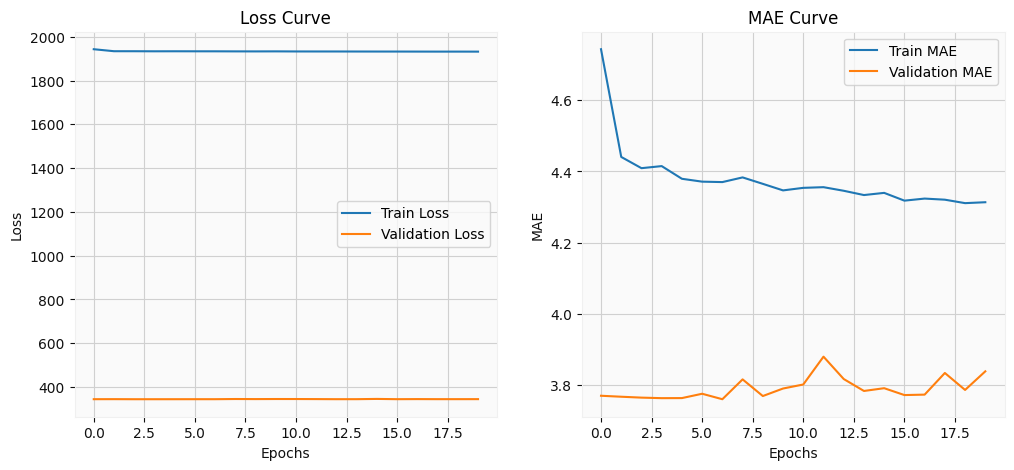

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Curve')
plt.legend()

plt.show()


In [36]:
optimizer = Adam(learning_rate=5e-6)  # Lower learning rate
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])


In [37]:
print("X_train Min:", X_train.min(), "Max:", X_train.max())
print("y_train Min:", y_train.min(), "Max:", y_train.max())


X_train Min: 0.0 Max: 1.0
y_train Min: 0.0 Max: 0.9959248176924091


In [38]:
model = Sequential([
    Input(shape=(60, 8)),

    Conv1D(32, kernel_size=3, activation='relu'),  
    MaxPooling1D(pool_size=2),

    LSTM(32, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(5)
])


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Compile the model with a low learning rate
model.compile(loss='mse', optimizer=Adam(learning_rate=5e-6), metrics=['mae'])

# Callbacks for intelligent monitoring
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# Train the model with adjustments for overfitting detection
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Print the final epoch results
final_val_loss = history.history['val_loss'][-1]
final_train_loss = history.history['loss'][-1]
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")

# Analyze for overfitting
if final_val_loss > final_train_loss * 1.2:
    print("Potential overfitting detected: Validation loss is significantly higher than training loss.")


In [43]:
import pickle
import joblib
import tensorflow as tf
import pandas as pd
import datetime

# === Add Timestamp for Versioning ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# === Save LSTM Model === (Fixed extension to .keras)
model.save(f"stock_lstm_checkpoint_{timestamp}.keras")

# === Save Training Variables with Pickle ===
with open(f"saved_session_{timestamp}.pkl", "wb") as f:
    pickle.dump({
        "ns_data": ns_data,
        "bo_data": bo_data,
        "nse_cleaned_data": nse_cleaned_data,
        "bse_cleaned_data": bse_cleaned_data,
        "enhanced_data": enhanced_data,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
        "history": history.history if 'history' in globals() else None
    }, f)

# === Save Large Data Separately Using Joblib ===
joblib.dump({
    "X": X,
    "y": y,
    "scaler_x": scaler_x,
    "scaler_y": scaler_y
}, f"large_data_{timestamp}.joblib")

# === Save Training History as CSV ===
if 'history' in globals():
    pd.DataFrame(history.history).to_csv(f"training_history_{timestamp}.csv", index=False)

print(f"All files saved with timestamp {timestamp}")

All files saved with timestamp 20250214_001456


In [2]:
import pickle
import joblib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# === STEP 1: Load the LSTM Model ===
timestamp = "20250214_001456"  # 🔄 Replace with your actual timestamp
model = load_model(f"stock_lstm_checkpoint_{timestamp}.keras")

# === STEP 2: Load Variables from Pickle ===
with open(f"saved_session_{timestamp}.pkl", "rb") as f:
    session_data = pickle.load(f)

# Extract training-related variables
ns_data = session_data["ns_data"]
bo_data = session_data["bo_data"]
nse_cleaned_data = session_data["nse_cleaned_data"]
bse_cleaned_data = session_data["bse_cleaned_data"]
enhanced_data = session_data["enhanced_data"]
scaler_x = session_data["scaler_x"]
scaler_y = session_data["scaler_y"]
history_data = session_data["history"]

# === STEP 3: Load Large Data from Joblib ===
large_data = joblib.load(f"large_data_{timestamp}.joblib")

X_train = large_data["X"]
y_train = large_data["y"]

# === STEP 4: Load Training History (for plotting) ===
history_df = pd.read_csv(f"training_history_{timestamp}.csv")

# === STEP 5: Recompile the Model ===
model.compile(loss='mse', optimizer=Adam(learning_rate=5e-6), metrics=['mae'])

# === STEP 6: Set Up Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# === STEP 7: Resume Training ===
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,  # Use 20% of data for validation
    callbacks=callbacks,
    verbose=1
)

# Print the final epoch results
final_val_loss = history.history['val_loss'][-1]
final_train_loss = history.history['loss'][-1]
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")

# Analyze for overfitting
if final_val_loss > final_train_loss * 1.2:
    print("⚠️ Potential overfitting detected: Validation loss is significantly higher than training loss.")


Epoch 1/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - loss: 0.1590 - mae: 0.3086 - val_loss: 0.0479 - val_mae: 0.1740 - learning_rate: 5.0000e-06
Epoch 2/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - loss: 0.1333 - mae: 0.2820 - val_loss: 0.0377 - val_mae: 0.1537 - learning_rate: 5.0000e-06
Epoch 3/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 0.1118 - mae: 0.2580 - val_loss: 0.0302 - val_mae: 0.1369 - learning_rate: 5.0000e-06
Epoch 4/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0958 - mae: 0.2387 - val_loss: 0.0250 - val_mae: 0.1239 - learning_rate: 5.0000e-06
Epoch 5/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - loss: 0.0820 - mae: 0.2205 - val_loss: 0.0194 - val_mae: 0.1087 - learning_rate: 5.0000e-06
Epoch 6/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.0714 - mae: 0.2056 - val_loss: 0.0155 - val_mae: 0.0964 - learning_rate: 5.0000e-06
Epoch 7/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - loss: 0.0618 - mae: 0.1910 - val_loss: 0.0

In [3]:
import pickle
import joblib
import tensorflow as tf
import pandas as pd
import datetime
import numpy as np

# === Get Current Timestamp ===
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# === Load Previous History ===
prev_timestamp = "20250214_001456"  # Your previous timestamp
try:
    previous_history_df = pd.read_csv(f"training_history_{prev_timestamp}.csv")
    previous_epochs = len(previous_history_df)
    print(f"Loaded previous history with {previous_epochs} epochs")
except FileNotFoundError:
    previous_history_df = pd.DataFrame()
    previous_epochs = 0
    print("No previous history found, starting fresh")

# === Combine Previous and New History ===
new_history_df = pd.DataFrame(history.history)
new_history_df.index = new_history_df.index + previous_epochs
combined_history_df = pd.concat([previous_history_df, new_history_df])

# === Save Updated LSTM Model ===
model.save(f"stock_lstm_checkpoint_{timestamp}.keras")

# === Save Training Variables with Pickle ===
with open(f"saved_session_{timestamp}.pkl", "wb") as f:
    pickle.dump({
        "ns_data": ns_data,
        "bo_data": bo_data,
        "nse_cleaned_data": nse_cleaned_data,
        "bse_cleaned_data": bse_cleaned_data,
        "enhanced_data": enhanced_data,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
        "history": combined_history_df.to_dict()  # Save combined history
    }, f)

# === Save Large Data Separately Using Joblib ===
joblib.dump({
    "X": X_train,
    "y": y_train,
    "scaler_x": scaler_x,
    "scaler_y": scaler_y
}, f"large_data_{timestamp}.joblib")

# === Save Combined Training History as CSV ===
combined_history_df.to_csv(f"training_history_{timestamp}.csv", index=False)

# === Print Summary of Saved Data ===
print(f"\nSaving Summary:")
print(f"Timestamp: {timestamp}")
print(f"Total epochs saved: {len(combined_history_df)}")
print(f"New epochs added: {len(new_history_df)}")
print(f"Files saved:")
print(f"- Model: stock_lstm_checkpoint_{timestamp}.keras")
print(f"- Session data: saved_session_{timestamp}.pkl")
print(f"- Large data: large_data_{timestamp}.joblib")
print(f"- Training history: training_history_{timestamp}.csv")

# === Optional: Generate Training Progress Plot ===
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.plot(combined_history_df['loss'], label='Training Loss')
    if 'val_loss' in combined_history_df.columns:
        plt.plot(combined_history_df['val_loss'], label='Validation Loss')
    plt.axvline(x=previous_epochs, color='r', linestyle='--', 
                label='New Training Start')
    plt.title('Training History (Combined)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'training_history_plot_{timestamp}.png')
    plt.close()
    print(f"- Training plot: training_history_plot_{timestamp}.png")
except Exception as e:
    print(f"Note: Could not generate training plot: {str(e)}")

Loaded previous history with 20 epochs

Saving Summary:
Timestamp: 20250214_100812
Total epochs saved: 60
New epochs added: 40
Files saved:
- Model: stock_lstm_checkpoint_20250214_100812.keras
- Session data: saved_session_20250214_100812.pkl
- Large data: large_data_20250214_100812.joblib
- Training history: training_history_20250214_100812.csv
- Training plot: training_history_plot_20250214_100812.png


In [4]:
import pandas as pd

prev_timestamp = "20250214_001456"  # Your previous training history
new_timestamp = "20250214_100812"   # Your latest training history

prev_history = pd.read_csv(f"training_history_{prev_timestamp}.csv")
new_history = pd.read_csv(f"training_history_{new_timestamp}.csv")

print(f"Previous Final Validation Loss: {prev_history['val_loss'].iloc[-1]}")
print(f"New Final Validation Loss: {new_history['val_loss'].iloc[-1]}")

if new_history['val_loss'].iloc[-1] > prev_history['val_loss'].iloc[-1] * 1.1:
    print("⚠️ Warning: Validation loss increased significantly! Model might be overfitting.")
else:
    print("✅ Validation loss is stable or improving.")


Previous Final Validation Loss: 344.848388671875
New Final Validation Loss: 0.0041593224741518
✅ Validation loss is stable or improving.


In [7]:
import pickle
import joblib
import tensorflow as tf
import pandas as pd
import numpy as np

# === Define Timestamp ===
timestamp = "20250214_100812"  # Use the saved timestamp

# === Load LSTM Model ===
model = tf.keras.models.load_model(f"stock_lstm_checkpoint_{timestamp}.keras")
print("✅ Model loaded successfully.")

# === Load Training Variables from Pickle ===
with open(f"saved_session_{timestamp}.pkl", "rb") as f:
    session_data = pickle.load(f)

# Extract Variables
ns_data = session_data["ns_data"]
bo_data = session_data["bo_data"]
nse_cleaned_data = session_data["nse_cleaned_data"]
bse_cleaned_data = session_data["bse_cleaned_data"]
enhanced_data = session_data["enhanced_data"]
scaler_x = session_data["scaler_x"]
scaler_y = session_data["scaler_y"]
history_dict = session_data["history"]

print("✅ Session data loaded successfully.")

# === Load Large Data from Joblib ===
large_data = joblib.load(f"large_data_{timestamp}.joblib")

# Extract X_train and y_train
X_train = large_data["X"]
y_train = large_data["y"]

print("✅ Large dataset loaded successfully.")

# === Load Training History ===
history_df = pd.read_csv(f"training_history_{timestamp}.csv")
print(f"✅ Training history loaded: {len(history_df)} epochs")

# === Summary ===
print("\n🔹 Loaded Data Summary:")
print(f"- Model: ✅ stock_lstm_checkpoint_{timestamp}.keras")
print(f"- Session Data: ✅ saved_session_{timestamp}.pkl")
print(f"- Large Data: ✅ large_data_{timestamp}.joblib")
print(f"- Training History: ✅ training_history_{timestamp}.csv")

# === Optional: Convert History Dict Back to DataFrame ===
history_df_loaded = pd.DataFrame(history_dict)
print("\n📊 Training History Preview:")
print(history_df_loaded.head())


✅ Model loaded successfully.
✅ Session data loaded successfully.
✅ Large dataset loaded successfully.
✅ Training history loaded: 60 epochs

🔹 Loaded Data Summary:
- Model: ✅ stock_lstm_checkpoint_20250214_100812.keras
- Session Data: ✅ saved_session_20250214_100812.pkl
- Large Data: ✅ large_data_20250214_100812.joblib
- Training History: ✅ training_history_20250214_100812.csv

📊 Training History Preview:
          loss       mae    val_loss   val_mae  learning_rate
0  1942.990967  4.743196  344.595703  3.769744            NaN
1  1933.893433  4.440598  344.824066  3.766990            NaN
2  1933.826782  4.409045  344.499481  3.764477            NaN
3  1933.499878  4.414865  344.492737  3.762980            NaN
4  1933.642334  4.379220  344.545105  3.763180            NaN


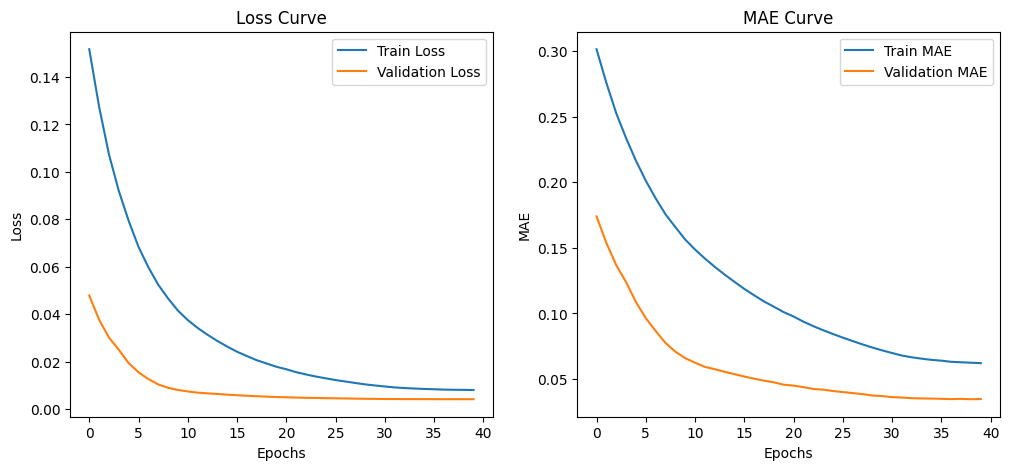

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Curve')
plt.legend()

plt.show()


In [9]:
import pandas as pd

# Assuming history.history is available
history_df = pd.DataFrame(history.history)

# Print loss values
print("\nEpoch-wise Loss:")
print(history_df[['loss', 'val_loss']])

# Print MAE values
print("\nEpoch-wise MAE:")
print(history_df[['mae', 'val_mae']])



Epoch-wise Loss:
        loss  val_loss
0   0.151699  0.047865
1   0.127470  0.037678
2   0.107366  0.030153
3   0.091985  0.024963
4   0.079369  0.019379
5   0.068387  0.015498
6   0.059801  0.012650
7   0.052408  0.010392
8   0.046638  0.008958
9   0.041489  0.008037
10  0.037511  0.007417
11  0.034206  0.006911
12  0.031334  0.006624
13  0.028711  0.006362
14  0.026342  0.006067
15  0.024165  0.005826
16  0.022336  0.005616
17  0.020582  0.005409
18  0.019213  0.005249
19  0.017820  0.005060
20  0.016791  0.004967
21  0.015547  0.004845
22  0.014584  0.004738
23  0.013711  0.004687
24  0.012952  0.004597
25  0.012227  0.004524
26  0.011614  0.004455
27  0.010986  0.004394
28  0.010405  0.004326
29  0.009944  0.004297
30  0.009513  0.004247
31  0.009119  0.004229
32  0.008854  0.004193
33  0.008654  0.004183
34  0.008481  0.004178
35  0.008352  0.004168
36  0.008203  0.004147
37  0.008135  0.004166
38  0.008096  0.004162
39  0.008021  0.004159

Epoch-wise MAE:
         mae   val_mae

In [10]:
import numpy as np

loss_diff = np.diff(history.history['loss'])
val_loss_diff = np.diff(history.history['val_loss'])

print("Average loss decrease per epoch:", np.mean(loss_diff))
print("Average validation loss decrease per epoch:", np.mean(val_loss_diff))


Average loss decrease per epoch: -0.003684053245263222
Average validation loss decrease per epoch: -0.0011206627823412418


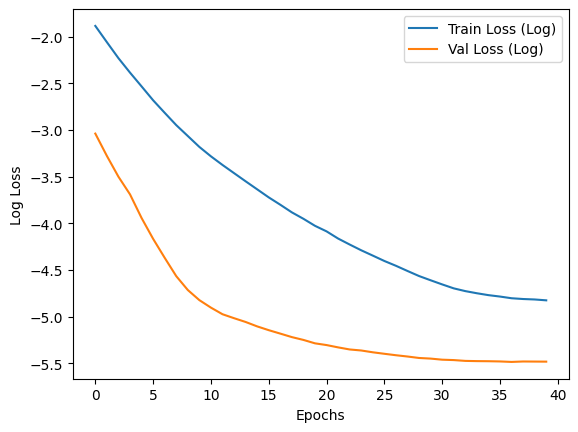

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, np.log(history.history['loss']), label='Train Loss (Log)')
plt.plot(history.epoch, np.log(history.history['val_loss']), label='Val Loss (Log)')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


In [12]:
recent_loss_change = history_df['loss'].iloc[-5:].diff().mean()
recent_val_loss_change = history_df['val_loss'].iloc[-5:].diff().mean()

print(f"Recent Loss Change (last 5 epochs): {recent_loss_change}")
print(f"Recent Val Loss Change (last 5 epochs): {recent_val_loss_change}")


Recent Loss Change (last 5 epochs): -8.280668407678604e-05
Recent Val Loss Change (last 5 epochs): -2.1368032321333885e-06


In [17]:
import pickle
import joblib
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# === Define Timestamp ===
timestamp = "20250214_100812"  # Use the saved timestamp

# === Load LSTM Model ===
model = tf.keras.models.load_model(f"stock_lstm_checkpoint_{timestamp}.keras")
print("✅ Model loaded successfully.")

# === Load Training Variables from Pickle ===
with open(f"saved_session_{timestamp}.pkl", "rb") as f:
    session_data = pickle.load(f)

# Extract Variables
ns_data = session_data["ns_data"]
bo_data = session_data["bo_data"]
nse_cleaned_data = session_data["nse_cleaned_data"]
bse_cleaned_data = session_data["bse_cleaned_data"]
enhanced_data = session_data["enhanced_data"]
scaler_x = session_data["scaler_x"]
scaler_y = session_data["scaler_y"]
history_dict = session_data["history"]

print("✅ Session data loaded successfully.")

# === Load Large Data from Joblib ===
large_data = joblib.load(f"large_data_{timestamp}.joblib")

# Extract X_train and y_train
X_train = large_data["X"]
y_train = large_data["y"]

print("✅ Large dataset loaded successfully.")

# === Reshape X_train for Scaling ===
num_samples, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(num_samples * time_steps, num_features)  # Flatten for scaling

# Scale X_train
X_train_scaled = scaler_x.transform(pd.DataFrame(X_train_reshaped, columns=scaler_x.feature_names_in_))


# Reshape back to 3D
X_train = X_train_scaled.reshape(num_samples, time_steps, num_features)

# === Scale y_train (Ensure Correct Shape) ===
expected_features = scaler_y.n_features_in_  # Get expected feature count

# Ensure y_train has the correct number of features
if y_train.ndim == 1:  
    y_train = y_train.reshape(-1, 1)  # Convert to 2D if needed

# If the shape does not match, refit scaler_y (as a last resort)
if y_train.shape[1] != expected_features:
    print(f"⚠️ Warning: y_train has {y_train.shape[1]} features, but scaler_y expects {expected_features}. Refitting scaler_y.")
    scaler_y = MinMaxScaler().fit(y_train)  # Refit on correct shape

# Apply scaling
y_train = scaler_y.transform(y_train)

# === Load Training History ===
history_df = pd.read_csv(f"training_history_{timestamp}.csv")
print(f"✅ Training history loaded: {len(history_df)} epochs")

# === Summary ===
print("\n🔹 Loaded Data Summary:")
print(f"- Model: ✅ stock_lstm_checkpoint_{timestamp}.keras")
print(f"- Session Data: ✅ saved_session_{timestamp}.pkl")
print(f"- Large Data: ✅ large_data_{timestamp}.joblib")
print(f"- Training History: ✅ training_history_{timestamp}.csv")

# === Convert History Dict Back to DataFrame ===
history_df_loaded = pd.DataFrame(history_dict)
print("\n📊 Training History Preview:")
print(history_df_loaded.head())


✅ Model loaded successfully.
✅ Session data loaded successfully.
✅ Large dataset loaded successfully.
✅ Training history loaded: 60 epochs

🔹 Loaded Data Summary:
- Model: ✅ stock_lstm_checkpoint_20250214_100812.keras
- Session Data: ✅ saved_session_20250214_100812.pkl
- Large Data: ✅ large_data_20250214_100812.joblib
- Training History: ✅ training_history_20250214_100812.csv

📊 Training History Preview:
          loss       mae    val_loss   val_mae  learning_rate
0  1942.990967  4.743196  344.595703  3.769744            NaN
1  1933.893433  4.440598  344.824066  3.766990            NaN
2  1933.826782  4.409045  344.499481  3.764477            NaN
3  1933.499878  4.414865  344.492737  3.762980            NaN
4  1933.642334  4.379220  344.545105  3.763180            NaN


In [18]:
# === Make Predictions ===
y_pred_scaled = model.predict(X_train)

# === Inverse Transform Predictions ===
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# === Display Sample Predictions ===
print("\n📊 Sample Predictions:")
for i in range(5):
    print(f"Actual: {y_train[i][0]:.2f} | Predicted: {y_pred[i][0]:.2f}")


3651/3651 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step

📊 Sample Predictions:
Actual: 0.00 | Predicted: 0.01
Actual: 0.00 | Predicted: 0.01
Actual: 0.00 | Predicted: 0.01
Actual: 0.00 | Predicted: 0.01
Actual: 0.00 | Predicted: 0.01


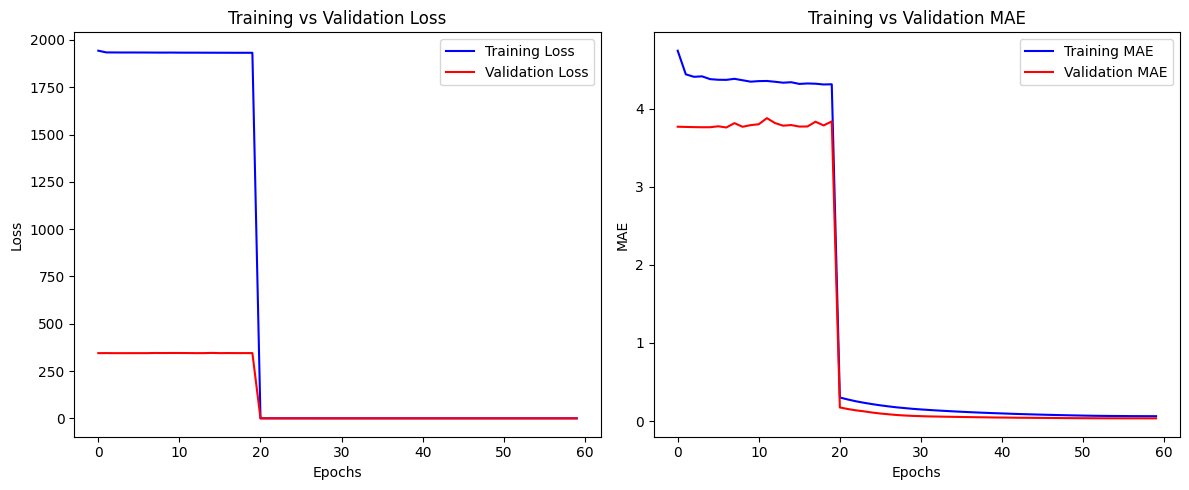

In [19]:
import matplotlib.pyplot as plt

# === Plot Loss ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df["loss"], label="Training Loss", color="blue")
plt.plot(history_df["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# === Plot MAE ===
plt.subplot(1, 2, 2)
plt.plot(history_df["mae"], label="Training MAE", color="blue")
plt.plot(history_df["val_mae"], label="Validation MAE", color="red")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.legend()

# === Show Plots ===
plt.tight_layout()
plt.show()


In [ ]:
%pip install keras-tuner

import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [22]:
def build_model(hp):
    model = keras.Sequential()
    
    # LSTM Layers (Tunable number of units)
    for i in range(hp.Int("num_layers", 1, 3)):  # 1 to 3 LSTM layers
        model.add(LSTM(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            return_sequences=True if i < hp.Int("num_layers", 1, 3) - 1 else False
        ))
        model.add(Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))  # Dropout

    # Output Layer
    model.add(Dense(1))

    # Compile Model
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    
    return model


In [ ]:
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create an instance of HyperParameters
hp = kt.HyperParameters()

tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="tuning_results",
    project_name="lstm_tuning"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=hp.Choice("batch_size", [16, 32, 64]))

Trial 1 Complete [00h 13m 32s]
val_loss: 0.0560920313000679

Best val_loss So Far: 0.0560920313000679
Total elapsed time: 00h 13m 32s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_layers
32                |192               |units_0
0.2               |0.3               |dropout
0.0005            |0.0001            |learning_rate
224               |32                |units_1
224               |32                |units_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
4794/5842 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0567 - mae: 0.1893

KeyboardInterrupt: 

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the tuner with early stopping for tuning
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="tuning_results",
    project_name="lstm_tuning"
)

# Track best val_loss
best_val_loss = np.inf
patience = 5  # Stop if no improvement in last 5 trials
stagnant_trials = 0

for trial in range(30):  # Limit to 30 trials max
    print(f"\n🔹 Running Trial #{trial + 1}...")

    # Run a trial
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                 batch_size=kt.HyperParameters().Choice("batch_size", [16, 32, 64]),
                 callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

    # Get the best val_loss from the current trial
    current_best = tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value("val_loss")

    # Check for improvement
    if current_best < best_val_loss:
        best_val_loss = current_best
        stagnant_trials = 0  # Reset counter if improvement
    else:
        stagnant_trials += 1  # Increase counter if no improvement

    # Stop tuning if val_loss hasn't improved in 'patience' trials
    if stagnant_trials >= patience:
        print("\n🚀 Early Stopping Activated: No improvement in last 5 trials.")
        break

# Get best hyperparameters
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n✅ Best Hyperparameters Found:")
for param in best_hyperparams.values:
    print(f"{param}: {best_hyperparams.get(param)}")


Trial 5 Complete [00h 12m 37s]
val_loss: 0.0560862198472023

Best val_loss So Far: 0.05608607828617096
Total elapsed time: 00h 49m 22s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
128               |192               |units_0
0.3               |0.5               |dropout
0.001             |0.0005            |learning_rate
64                |160               |units_1
192               |128               |units_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
4596/4673 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0563 - mae: 0.1897

KeyboardInterrupt: 

In [30]:
# Get best hyperparameters from tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n✅ Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")



✅ Best Hyperparameters:
num_layers: 1
units_0: 192
dropout: 0.5
learning_rate: 0.0005
units_1: 160
units_2: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


In [37]:
import os
import time
import pickle
import numpy as np

# === 1️⃣ Set TensorFlow Environment for CPU Optimization ===
os.environ['TF_INTER_OP_PARALLELISM_THREADS'] = '4'  # Adjust for CPU cores
os.environ['TF_INTRA_OP_PARALLELISM_THREADS'] = '4'  # Adjust for CPU cores

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print("✅ TensorFlow OneDNN optimizations enabled.")

# === 2️⃣ Enable Mixed Precision (float16) with Safe Check ===
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed Precision Enabled (float16)")
except ImportError:
    print("⚠️ Mixed Precision not available. Proceeding with float32.")

# === 3️⃣ Hyperparameters ===
batch_size = 16  # Smaller for faster training on CPU
epochs = 5

# === 4️⃣ Load Data with tf.data Pipeline ===
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# === 5️⃣ Build Optimized LSTM Model ===
def build_optimized_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.LSTM(128, return_sequences=True, dropout=0.5),
        layers.LSTM(64, dropout=0.5),
        layers.Dense(5)  # Predicting 5 outputs
    ])
    
    # === Use SGD with Momentum for Faster CPU Training ===
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
    # === JIT Compilation for Speed-up ===
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae'],
        jit_compile=True  # Enable JIT Compilation
    )
    return model

# === 6️⃣ Callbacks with Error-Proofing ===
try:
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1
    )
except Exception as e:
    print(f"⚠️ Callback Error: {e}")
    early_stopping, reduce_lr = None, None

# === 7️⃣ Train and Time the Model ===
model = build_optimized_model()

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[cb for cb in [early_stopping, reduce_lr] if cb is not None],
    verbose=1
)

end_time = time.time()
print(f"\n🏁 Training Completed in {end_time - start_time:.2f} seconds")

# === 8️⃣ Save Model and History Safely ===
try:
    model.save("optimized_lstm_model.h5")
    with open("optimized_training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print("✅ Model and Training History Saved.")
except Exception as e:
    print(f"⚠️ Error Saving Model/History: {e}")

# === 9️⃣ Print Final Results ===
try:
    print(f"\n✅ Best Validation Loss: {min(history.history['val_loss'])}")
except Exception:
    print("⚠️ Validation loss not found in history.")


✅ TensorFlow OneDNN optimizations enabled.
✅ Mixed Precision Enabled (float16)
Epoch 1/5
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 241s 51ms/step - loss: 0.0017 - mae: 0.0198 - val_loss: 2.7210e-04 - val_mae: 0.0039 - learning_rate: 0.0100
Epoch 2/5
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 286s 61ms/step - loss: 3.2162e-04 - mae: 0.0069 - val_loss: 2.7473e-04 - val_mae: 0.0046 - learning_rate: 0.0100
Epoch 3/5
4672/4673 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.0564e-04 - mae: 0.0057
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 284s 61ms/step - loss: 3.0564e-04 - mae: 0.0057 - val_loss: 2.7184e-04 - val_mae: 0.0036 - learning_rate: 0.0100
Epoch 4/5
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 238s 51ms/step - loss: 3.0172e-04 - mae: 0.0052 - val_loss: 2.7115e-04 - val_mae: 0.0037 - learning_rate: 0.0050
Epoch 5/5
4672/4673 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.9502e-04 - mae: 0.0050
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.002499999944120


🏁 Training Completed in 1300.70 seconds
✅ Model and Training History Saved.

✅ Best Validation Loss: 0.000270769844064489


In [5]:
import tensorflow as tf
import numpy as np

# === Load Model ===
model = tf.keras.models.load_model("optimized_lstm_model.h5")
print("✅ Model Loaded Successfully")

# === Load Data Using Path Directly ===
def npy_dataset(x_path, y_path, batch_size=16):
    def generator():
        X = np.load(x_path, mmap_mode='r')  # Load from path directly
        Y = np.load(y_path, mmap_mode='r')  # Load from path directly
        for i in range(len(X)):
            yield X[i], Y[i]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(60, 8), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32),
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# === Use Dataset for Testing ===
test_dataset = npy_dataset("X_stock_sequences.npy", "y_stock_targets.npy")

# Evaluate on streamed dataset
test_loss, test_mae = model.evaluate(test_dataset, verbose=1)
print(f"\n🎯 Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")


✅ Model Loaded Successfully
  79472/Unknown 2583s 32ms/step - loss: 0.0676 - mean_absolute_error: 0.1691

KeyboardInterrupt: 

In [6]:
import tensorflow as tf
import numpy as np
import time

# === Load Model with JIT Compilation ===
model = tf.keras.models.load_model("optimized_lstm_model.h5")
model.compile(jit_compile=True)
print("✅ Model Loaded with JIT Compilation")

# === Load Data Using Streaming from Numpy ===
def npy_dataset(x_path, y_path, batch_size=128, sample_limit=50000):
    def generator():
        X = np.load(x_path, mmap_mode='r')
        Y = np.load(y_path, mmap_mode='r')
        limit = min(sample_limit, len(X))
        for i in range(limit):
            yield X[i], Y[i]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(60, 8), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32),
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# === Use Dataset for Testing (Limited to 50k samples) ===
test_dataset = npy_dataset("X_stock_sequences.npy", "y_stock_targets.npy", batch_size=128, sample_limit=50000)

# === Measure Evaluation Time ===
start_time = time.time()
test_loss, test_mae = model.evaluate(test_dataset, verbose=1)
end_time = time.time()

print(f"\n🎯 Optimized Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")
print(f"⏱️ Evaluation Time: {end_time - start_time:.2f} seconds")


✅ Model Loaded with JIT Compilation
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - loss: 0.0671 - mean_absolute_error: 0.1712

🎯 Optimized Test Loss: 0.067087, Test MAE: 0.171121
⏱️ Evaluation Time: 83.28 seconds


c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ Model Loaded and JIT Compilation Enabled
🚀 Predicting...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


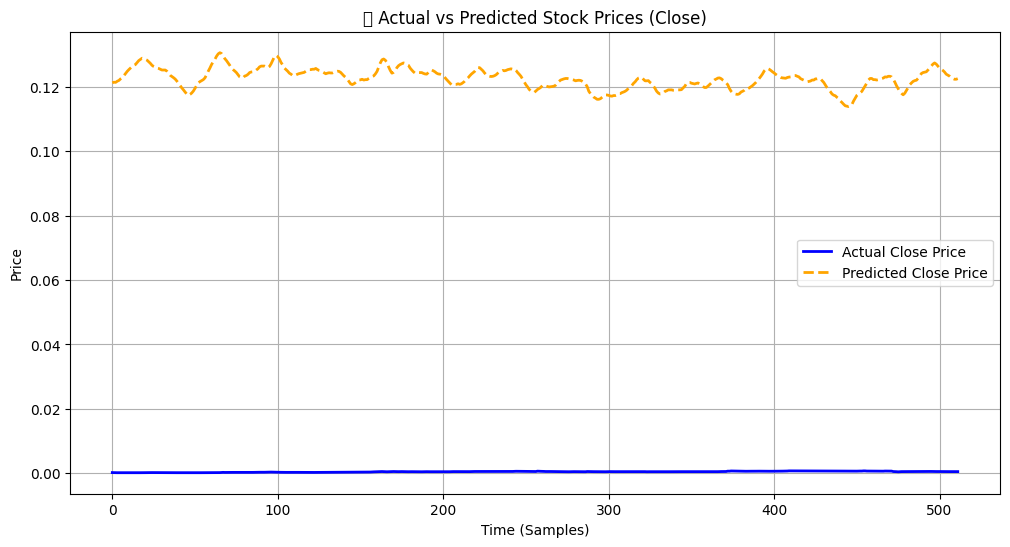

🎯 Close Price MAE: 0.122102
🎯 Close Price RMSE: 0.122144


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1️⃣ Load Model (with JIT Compile for Speed) ===
model = tf.keras.models.load_model("optimized_lstm_model.h5", compile=False)
model.compile(jit_compile=True)
print("✅ Model Loaded and JIT Compilation Enabled")

# === 2️⃣ Streaming Dataset from .npy Files ===
def npy_dataset(x_path, y_path, batch_size=16):
    def generator():
        X = np.load(x_path, mmap_mode='r')
        Y = np.load(y_path, mmap_mode='r')
        for i in range(min(len(X), 512)):  # Limit to 512 samples
            yield X[i], Y[i]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(60, 8), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32),
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# === 3️⃣ Load Dataset (Stream only first 512 samples) ===
test_dataset = npy_dataset("X_stock_sequences.npy", "y_stock_targets.npy")

# === 4️⃣ Predict Using Dataset ===
print("🚀 Predicting...")
predictions = model.predict(test_dataset, verbose=1, steps=32)  # 32 steps x batch_size 16 = 512 samples
actuals = np.array([y.numpy() for _, y in test_dataset.unbatch().take(512)])

# === 5️⃣ Plot Predictions vs Actual (Close Price) ===
plt.figure(figsize=(12, 6))
plt.plot(actuals[:, 0], label="Actual Close Price", color="blue", linewidth=2)
plt.plot(predictions[:, 0], label="Predicted Close Price", color="orange", linestyle="--", linewidth=2)
plt.title("📊 Actual vs Predicted Stock Prices (Close)")
plt.xlabel("Time (Samples)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# === 6️⃣ Display Metrics (on Close Price) ===
# === 6️⃣ Display Metrics (on Close Price) ===
mae = mean_absolute_error(actuals[:, 0], predictions[:, 0])
mse = mean_squared_error(actuals[:, 0], predictions[:, 0])
rmse = np.sqrt(mse)

print(f"🎯 Close Price MAE: {mae:.6f}")
print(f"🎯 Close Price RMSE: {rmse:.6f}")


In [40]:
import pandas as pd
import numpy as np
import os
import joblib
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler

def load_all_csvs(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = []
    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        df['Stock'] = file
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=False)

def add_technical_indicators(df):
    df = df.copy()
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['EMA_12'] = EMAIndicator(df['Close'], window=12).ema_indicator()
    df['EMA_26'] = EMAIndicator(df['Close'], window=26).ema_indicator()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Hist'] = macd.macd_diff()
    df['RSI'] = RSIIndicator(df['Close']).rsi()
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    bb = BollingerBands(df['Close'])
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Middle'] = bb.bollinger_mavg()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
    vwap = VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume'])
    df['VWAP'] = vwap.volume_weighted_average_price()
    df['Price_Change'] = df['Close'].diff()
    df['Returns'] = df['Close'].pct_change()
    df['Daily_Volatility'] = df['Returns'].rolling(window=20).std()
    df['Daily_Range'] = df['High'] - df['Low']
    df['Daily_Range_Pct'] = df['Daily_Range'] / df['Open']
    df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_MA_50'] = df['Volume'].rolling(window=50).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    return df

def prepare_sequences(df, sequence_length=60, forecast_horizon=5):
    feature_columns = ['Close', 'Volume', 'RSI', 'MACD', 'BB_Width', 'Daily_Volatility', 'Volume_Ratio', 'Price_Position']
    df = df.dropna(subset=feature_columns)
    scaler = joblib.load('scaler.pkl') if os.path.exists('scaler.pkl') else MinMaxScaler()
    scaled_data = scaler.fit_transform(df[feature_columns]) if not os.path.exists('scaler.pkl') else scaler.transform(df[feature_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=feature_columns, index=df.index)
    X, y = [], []
    for i in range(len(scaled_df) - sequence_length - forecast_horizon + 1):
        X.append(scaled_df.iloc[i:(i + sequence_length)].values)
        y.append(scaled_df.iloc[i + sequence_length:i + sequence_length + forecast_horizon]['Close'].values)
    return np.array(X), np.array(y), scaler

if __name__ == "__main__":
    folder_path = r"C:\Users\KIIT\Desktop\Stock-Market-Dashboard\cleaned_data"
    stock_data = load_all_csvs(folder_path)
    enhanced_data = add_technical_indicators(stock_data)
    X, y, scaler = prepare_sequences(enhanced_data)
    print("Feature engineering complete.")
    print(f"Input shape: {X.shape}")
    print(f"Output shape: {y.shape}")
    print("\nFeatures added:", enhanced_data.columns.tolist())


C:\Users\KIIT\AppData\Local\Temp\ipykernel_12280\2488799249.py:43: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change()


Feature engineering complete.
Input shape: (7015920, 60, 8)
Output shape: (7015920, 5)

Features added: ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Anomaly', 'Stock', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'Stoch_K', 'Stoch_D', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'VWAP', 'Price_Change', 'Daily_Volatility', 'Daily_Range', 'Daily_Range_Pct', 'Price_Position', 'Volume_MA_20', 'Volume_MA_50', 'Volume_Ratio']


In [42]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved successfully.")


Scaler saved successfully.


✅ Model Loaded Successfully
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step

 Model Evaluation :
Mean Absolute Error (MAE): 0.171619
Root Mean Squared Error (RMSE): 0.258629


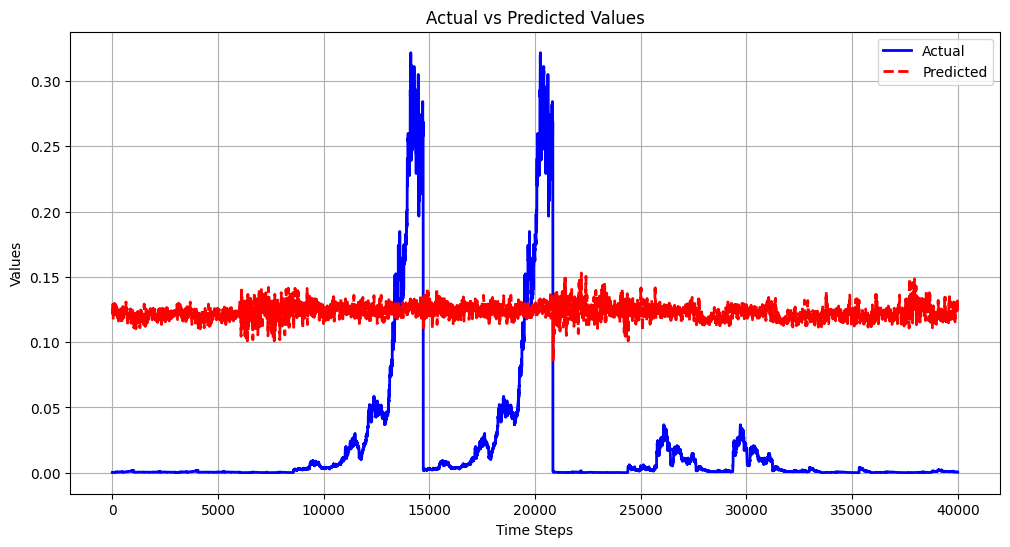

In [64]:

# Load the model
model = tf.keras.models.load_model("C:/Users/KIIT/Desktop/Stock-Market-Dashboard/stocksim/backend/training/optimized_lstm_model.h5")
print("✅ Model Loaded Successfully")
X_test = np.load("C:/Users/KIIT/Desktop/Stock-Market-Dashboard/stocksim/backend/training/X_stock_sequences.npy", mmap_mode="r")[:40000]
y_test = np.load("C:/Users/KIIT/Desktop/Stock-Market-Dashboard/stocksim/backend/training/y_stock_targets.npy", mmap_mode="r")[:40000]

# Make predictions
y_pred = model.predict(X_test, batch_size=32)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n Model Evaluation :")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Visualize first 100 predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:40000, 0], label="Actual", color="blue", linewidth=2)
plt.plot(y_pred[:40000, 0], label="Predicted", color="red", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import numpy as np
import tensorflow as tf

# Load data efficiently using tf.data
def load_data(file_path):
    return np.load(file_path, mmap_mode='r')

X_stock_sequences = load_data(r"C:/Users/KIIT/Desktop/Stock-Market-Dashboard/stocksim/backend/training/X_stock_sequences.npy")
y_stock_targets = load_data(r"C:/Users/KIIT/Desktop/Stock-Market-Dashboard/stocksim/backend/training/y_stock_targets.npy")

BATCH_SIZE = 16

def stock_data_generator():
    for i in range(0, len(X_stock_sequences), BATCH_SIZE):
        X_batch = X_stock_sequences[i:i + BATCH_SIZE]  # Shape: (batch_size, seq_len, features)
        y_batch = y_stock_targets[i:i + BATCH_SIZE]  # Shape: (batch_size,)
        yield X_batch, y_batch

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(
    stock_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, X_stock_sequences.shape[1], X_stock_sequences.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_stock_sequences.shape[1], X_stock_sequences.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mse')

# Train model with error handling
try:
    model.fit(train_dataset, epochs=30, verbose=1)
    model.save("stock_prediction_model.h5")
    print("Model training and saving completed successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

# Function to make predictions
def predict_stock_price(model, stock_sequence):
    stock_sequence = np.expand_dims(stock_sequence, axis=0)  # Add batch dimension
    prediction = model.predict(stock_sequence)
    return prediction[0][0]

# Example usage
# Load a sample stock sequence for prediction
sample_stock_sequence = X_stock_sequences[0]  # Replace with actual user input
predicted_price = predict_stock_price(model, sample_stock_sequence)
print(f"Predicted stock price: {predicted_price}")

Epoch 1/30


An error occurred: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element of shape (16, 5) where an element of shape (16,) was expected.
Traceback (most recent call last):

  File "c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)

  File "c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (16, 5) where an element of shape (16,) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_8271]
1/1 ━━━━━━

In [59]:
import nbformat
import base64
from fpdf import FPDF

def extract_outputs(notebook_path, pdf_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
    
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", '', 12)
    
    for cell in nb['cells']:
        if cell['cell_type'] == 'code' and 'outputs' in cell:
            for output in cell['outputs']:
                if 'text' in output:
                    pdf.multi_cell(0, 10, output['text'].encode('latin-1', 'ignore').decode('latin-1'))
                elif 'data' in output:
                    if 'text/plain' in output['data']:
                        pdf.multi_cell(0, 10, output['data']['text/plain'].encode('latin-1', 'ignore').decode('latin-1'))
                    if 'image/png' in output['data']:
                        img_data = base64.b64decode(output['data']['image/png'])
                        img_path = f'output.png'
                        with open(img_path, 'wb') as img_file:
                            img_file.write(img_data)
                        pdf.image(img_path, x=10, w=180)
    
    pdf.output(pdf_path, 'F')

extract_outputs('model.ipynb', 'output.pdf')
